In [19]:
import potcorr
import psutil
import os
import lab
import numpy as np
import pickle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv
import sys
#from pympler import asizeof
import io_xsf 
import matplotlib.pyplot as plt

In [2]:
cell = lab.bn_12x12
# cell = lab.mos2_tt
#cell = lab.bn_6x6
print('Starting job for '+cell['prefix']+'...')

#Eps0 =  read_eps.Epsmat(cell['folder']+'chi0mat.h5')
#Eps1 = read_eps.Epsmat(cell['folder']+'chimat.h5')
#np.save(cell['folder']+'chi0mat.npy', Eps1.mat)

ttkw=potcorr.PotCorr(cell)
print(ttkw.prefix)
print(ttkw.lattpara_unit)
# print(type(mos2.lattpara_unit))

ttkw.fft_init()
ttkw.get_vcoul()
ttkw.epsmat_init_interp(G_vec2ind_dict=cell['folder_G_info']+'G_vec2ind.pkl',
                        G_ind2vec_dict=cell['folder_G_info']+'G_ind2vec.pkl')
#print(ttkw.g_tuple_floor_tt)
#print(ttkw.g_rhoind_tt)
#print(ttkw.g_tuple_q_tt)

with open(cell['folder_model']+'model_all_re.pkl','rb') as file:
    model_all_re = pickle.load(file)
with open(cell['folder_model']+'model_all_im.pkl','rb') as file:
    model_all_im = pickle.load(file)
with open(cell['folder_G_info']+'Gind_list.pkl','rb') as file:
    Gind_list = pickle.load(file)




Starting job for bn...
bn
[ 2.51  2.51 25.  ]
Begin FFT grids Initialization
FFT grids:   216    216    180
Constructing Coulomb kernel...
ibrav= 4


f:\code\charged_defect\potcorr.py:77: RuntimeWarning: divide by zero encountered in divide
  self.v_coul = 8*np.pi/(self.k_squared)
f:\code\charged_defect\potcorr.py:81: RuntimeWarning: divide by zero encountered in divide
  self.v_coul2d = 8*np.pi/(self.k_squared)*(1-np.exp(-0.5*self.kxy*self.lattpara[2])*np.cos(0.5*self.fft_kzz*self.lattpara[2]))
f:\code\charged_defect\potcorr.py:81: RuntimeWarning: invalid value encountered in multiply
  self.v_coul2d = 8*np.pi/(self.k_squared)*(1-np.exp(-0.5*self.kxy*self.lattpara[2])*np.cos(0.5*self.fft_kzz*self.lattpara[2]))


0 / 216
1 / 216
2 / 216
3 / 216
4 / 216
5 / 216
6 / 216
7 / 216
8 / 216
9 / 216
10 / 216
11 / 216
12 / 216
13 / 216
14 / 216
15 / 216
16 / 216
17 / 216
18 / 216
19 / 216
20 / 216
21 / 216
22 / 216
23 / 216
24 / 216
25 / 216
26 / 216
27 / 216
28 / 216
29 / 216
30 / 216
31 / 216
32 / 216
33 / 216
34 / 216
35 / 216
36 / 216
37 / 216
38 / 216
39 / 216
40 / 216
41 / 216
42 / 216
43 / 216
44 / 216
45 / 216
46 / 216
47 / 216
48 / 216
49 / 216
50 / 216
51 / 216
52 / 216
53 / 216
54 / 216
55 / 216
56 / 216
57 / 216
58 / 216
59 / 216
60 / 216
61 / 216
62 / 216
63 / 216
64 / 216
65 / 216
66 / 216
67 / 216
68 / 216
69 / 216
70 / 216
71 / 216
72 / 216
73 / 216
74 / 216
75 / 216
76 / 216
77 / 216
78 / 216
79 / 216
80 / 216
81 / 216
82 / 216
83 / 216
84 / 216
85 / 216
86 / 216
87 / 216
88 / 216
89 / 216
90 / 216
91 / 216
92 / 216
93 / 216
94 / 216
95 / 216
96 / 216
97 / 216
98 / 216
99 / 216
100 / 216
101 / 216
102 / 216
103 / 216
104 / 216
105 / 216
106 / 216
107 / 216
108 / 216
109 / 216
110 / 216


In [3]:
flatten_gind = ttkw.g_rhoind_tt.flatten()
flatten_qvec = ttkw.g_tuple_q_tt.flatten()
flatten_vcoul = ttkw.v_coul.flatten()

In [4]:
val_size = len(np.where(flatten_gind < len(Gind_list))[0])

In [15]:
nq_=144
eps_mat_q = np.zeros([nq_,len(Gind_list),len(Gind_list) ], dtype=complex)

In [16]:
#eps_values = np.zeros((val_size*len(Gind_list), 1),dtype=complex)
#eps_indices_j = np.zeros(val_size*len(Gind_list),dtype=int)
#eps_indices_i = np.zeros(val_size*len(Gind_list),dtype=int)
start_idx = 0
for i in range(len(Gind_list)):
    print(i)
    g_qvec_ind_i=np.where(flatten_gind==i)[0]
    vcoul_values = flatten_vcoul[g_qvec_ind_i].reshape(-1,1)
    for j in range(len(Gind_list)):
        #print(j)
        g_qvec_ind_j=np.where(flatten_gind==j)[0]
        end_idx = start_idx+len(g_qvec_ind_j)
        qinp_set = np.array([np.array([a[0],a[1]]) for a in flatten_qvec[g_qvec_ind_j]])
        #print(flatten_qvec[g_qvec_ind])
        g0_,g1_ = i,j
        chi_re_set = model_all_re[f'model_{g0_}_{g1_}'].predict(qinp_set)
        chi_im_set = model_all_im[f'model_{g0_}_{g1_}'].predict(qinp_set)
        chi_set = chi_re_set + 1j*chi_im_set
        eps_mat_q[:,i,j]=chi_set.flatten()
        #eps_values[start_idx:end_idx] = chi_set#*vcoul_values
        #if i == j:
        #    eps_values[start_idx:end_idx] = eps_values[start_idx:end_idx]+1
        #eps_indices_j[start_idx:end_idx] = g_qvec_ind_j
        #eps_indices_i[start_idx:end_idx] = g_qvec_ind_i
        start_idx = end_idx
        #print(chi_set)
        #print(g_qvec_ind)
#print(chi_values)
#print([x for x in chi_indices])
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


In [17]:
np.shape(eps_mat_q[1])

(211, 211)

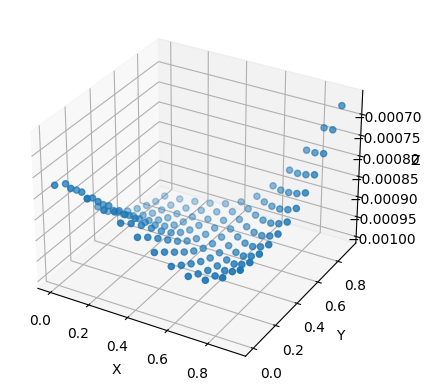

In [24]:
qinp_set
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
ax.scatter(qinp_set[:,0], qinp_set[:, 1],eps_mat_q[:,180,20] )

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [25]:
ttkw.read_chi()

Reading Chi matrix hdf5 files


In [26]:
ttkw.get_chimat()

Constructing chi_mat of number 1/144 q-point
Constructing chi_mat of number 2/144 q-point
Constructing chi_mat of number 3/144 q-point
Constructing chi_mat of number 4/144 q-point
Constructing chi_mat of number 5/144 q-point
Constructing chi_mat of number 6/144 q-point
Constructing chi_mat of number 7/144 q-point
Constructing chi_mat of number 8/144 q-point
Constructing chi_mat of number 9/144 q-point
Constructing chi_mat of number 10/144 q-point
Constructing chi_mat of number 11/144 q-point
Constructing chi_mat of number 12/144 q-point
Constructing chi_mat of number 13/144 q-point
Constructing chi_mat of number 14/144 q-point
Constructing chi_mat of number 15/144 q-point
Constructing chi_mat of number 16/144 q-point
Constructing chi_mat of number 17/144 q-point
Constructing chi_mat of number 18/144 q-point
Constructing chi_mat of number 19/144 q-point
Constructing chi_mat of number 20/144 q-point
Constructing chi_mat of number 21/144 q-point
Constructing chi_mat of number 22/144 q-poi

In [33]:
for i0_ in Gind_list:
    for i1_ in Gind_list:
        iix0, iiy0, iiz0 = ttkw.Chi0.G_ind2vec[i0_]
        iix1, iiy1, iiz1 = ttkw.Chi0.G_ind2vec[i1_]
        g0_ = [iix0, iiy0, iiz0]
        g1_ = [iix1, iiy1, iiz1]
        eps_Re_ = []
        eps_Im_ = []
        q_ = ttkw.Chi1.qpts[:]
        q0_ = ttkw.Chi0.qpts[:]
        q0_abs_ = np.sqrt((q0_[:,0])**2+ (np.sqrt(3)/3*(q0_[:,0])+2*np.sqrt(3)/3*(q0_[:,1]))**2)
        q1_abs_ = np.sqrt((q_[:,0])**2+ (np.sqrt(3)/3*(q_[:,0])+2*np.sqrt(3)/3*(q_[:,1]))**2)
        for i in range(0):
            #print(i)
            qind_ = i
            g_vec0_ = tuple(g0_)
            g_vec1_ = tuple(g1_)
            gind_rho0_ = ttkw.Chi0.G_vec2ind[g_vec0_]
            gind_rho1_ = ttkw.Chi0.G_vec2ind[g_vec1_]
            gind_eps0_ = ttkw.Chi0.gind_rho2eps[qind_, gind_rho0_]
            gind_eps1_ = ttkw.Chi0.gind_rho2eps[qind_, gind_rho1_]
            if (gind_eps0_ > 1000 or gind_eps1_ > 1000):
                continue     
            mat_Re_ = ttkw.Chi0.mat[qind_,0,0,gind_eps0_-1,gind_eps1_-1,0]
            mat_Im_ = ttkw.Chi0.mat[qind_,0,0,gind_eps0_-1,gind_eps1_-1,1]
            eps_Re_.append(mat_Re_)
            eps_Im_.append(mat_Im_)
        #    q_abs_ = np.hstack((np.array([]),q0_abs_))
        q_abs_ = []

        for i in range(0,144):
            #print(i)
            qind_ = i
            g_vec0_ = tuple(g0_)
            g_vec1_ = tuple(g1_)
            gind_rho0_ = ttkw.Chi1.G_vec2ind[g_vec0_]
            gind_rho1_ = ttkw.Chi1.G_vec2ind[g_vec1_]
            gind_eps0_ = ttkw.Chi1.gind_rho2eps[qind_, gind_rho0_]
            gind_eps1_ = ttkw.Chi1.gind_rho2eps[qind_, gind_rho1_]
            if (gind_eps0_ > 1000 or gind_eps1_ > 1000):
                continue     
            mat_Re_ = ttkw.Chi1.mat[qind_,0,0,gind_eps0_-1,gind_eps1_-1,0]
            mat_Im_ = ttkw.Chi1.mat[qind_,0,0,gind_eps0_-1,gind_eps1_-1,1]
            eps_Re_.append(mat_Re_)
            eps_Im_.append(mat_Im_)
        q_abs_ = np.hstack((q_abs_, q1_abs_[0:] ))

        y_re_data = np.array(eps_Re_)[:,np.newaxis]
        y_im_data = np.array(eps_Im_)[:,np.newaxis]
        if len(y_re_data) < 144:
            continue

        qpt = q_[:,:2]
        #print(qpt)
        #degree = 9
        #model_2d = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        #model_2d.fit(qpt, y_re_data)


        #q_inp = np.random.rand(500,2)
        #y_pred = model_2d.predict(q_inp)
        #q_zero = np.array([[0,0]])
        #y_zero = model_2d.predict(q_zero)
        #params = model_2d.named_steps['linearregression'].coef_
        #intercept = model_2d.named_steps['linearregression'].intercept_
        
        #print('Intercept: ', intercept)
        #print('Coefficients: ', params)

        #fig = plt.figure()
        #ax = fig.add_subplot(111, projection='3d')

        # Create a scatter plot
        #ax.scatter(qpt[:, 0], qpt[:, 1], y_re_data)
        #ax.scatter(qinp_set[:,0], qinp_set[:, 1],eps_mat_q[:,i0_,i1_] )
    #    ax.scatter(q_inp[:, 0], q_inp[:, 1], y_pred)
    #    ax.scatter(q_zero[:,0], q_zero[:,1], y_zero)
        # Set labels
        #ax.set_xlabel('X')
        #ax.set_ylabel('Y')
        #ax.set_zlabel('Z')

        plt.show()
        #print(np.average(y_re_data-np.real(eps_mat_q[:,i0_,i1_])))

6.299445438878245e-11
-6.220036477368819e-11
-6.21985327504291e-11
5.988192916387064e-11
5.98768242742372e-11
-5.6223544531472686e-11
-5.6212919023583156e-11
5.1499624293509666e-11
5.148117991040036e-11
-4.603575821196595e-11
-4.6007488976162544e-11
4.0166622310875584e-11
4.012647217885678e-11
-3.42003276372027e-11
-3.414617631107547e-11
2.8392927337525554e-11
2.8323032169768414e-11
-2.2936733777293535e-11
-2.2850050169899286e-11
1.7959680778307704e-11
1.7856318415057603e-11
-1.3532750301874728e-11
-1.3413864562144626e-11
-1.2018647266169074e-08
-5.9947662538064974e-09
-5.994935152550296e-09
6.0284496702101256e-09
6.028330907338611e-09
1.2030859967722248e-08
1.180647186010925e-08
1.180649029082338e-08
5.888865377973174e-09
5.888831841677862e-09
5.888998741950614e-09
5.8890456328325665e-09
-5.92234092744599e-09
-5.922292975553084e-09
-5.922185388632209e-09
-5.922207872968115e-09
-1.1818871288547557e-08
-1.1818854911274862e-08
-1.1189805937334971e-08
-1.1189843017531138e-08
-5.5810346296

In [6]:
eps_mat = csr_matrix((eps_values.flatten(),(eps_indices_i, eps_indices_j)),shape=(len(flatten_gind), len(flatten_gind)))

In [7]:
Rho1 = io_xsf.Rho(cell['folder']+'drho.xsf')

In [8]:
rho_vec = np.fft.fftn(Rho1.rho).flatten()

In [9]:
flatten_pot_tot = rho_vec*flatten_vcoul

In [10]:
pot_bare_vec = eps_mat@(flatten_pot_tot.reshape(-1,1))

In [11]:
flatten_pot_bare=pot_bare_vec.flatten()

In [12]:
rho_bare = np.fft.ifftn(flatten_pot_bare.reshape(216,216,180))

In [13]:
Rho1.rho = np.real(rho_bare)

In [14]:
io_xsf.write_xsf(Rho1, xsf_type='rho', filedir=cell['folder']+'test.xsf')